In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

[ 3.06161700e-16  5.00000000e+00 -8.66025404e+00]
Step 2: NS and sky hit cleared
Step 3: Stars hit cleared
Step 4: Image saved
time elapsed 1315.342389 sec


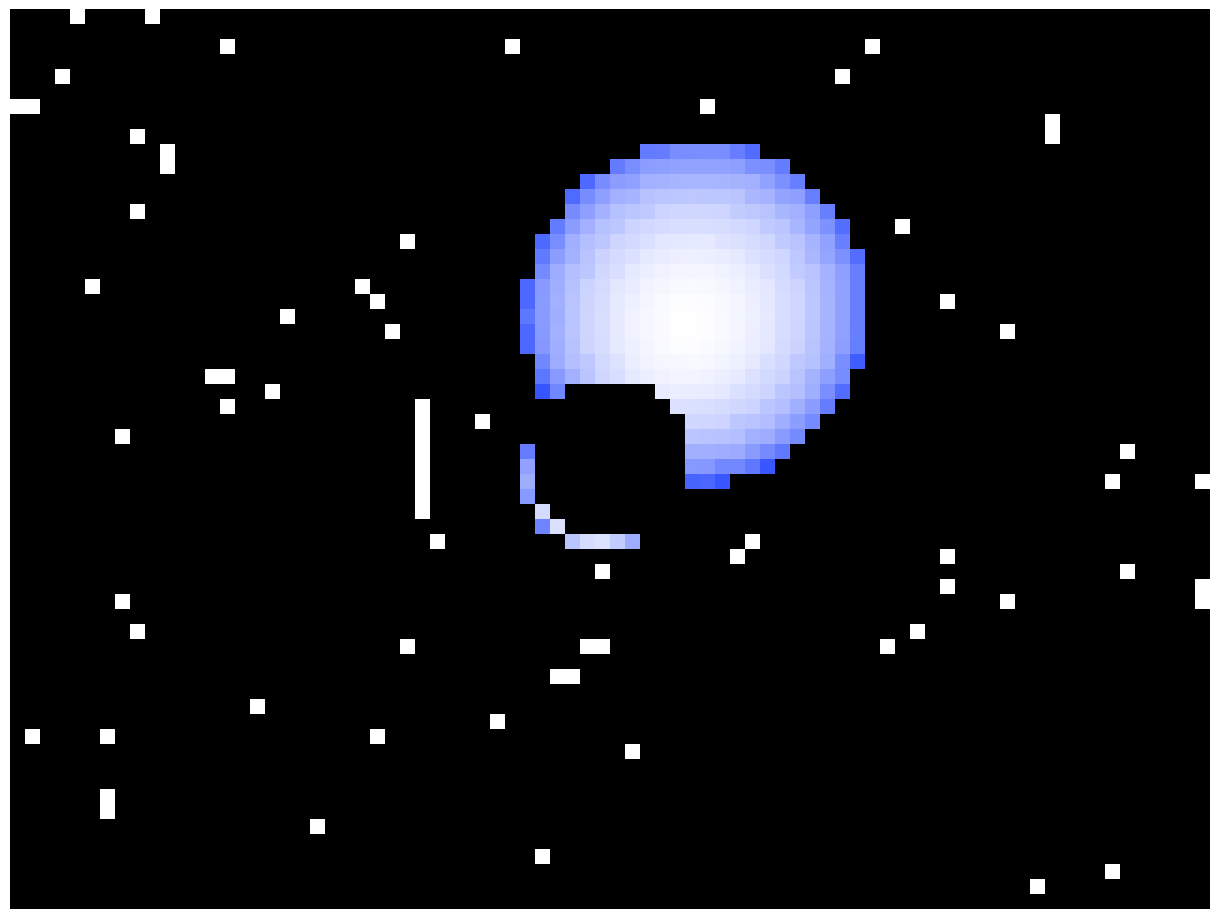

In [13]:
image_width, image_height = 80,60
traj_dir  = os.getcwd() + '/trajectories/'
traj_filename = 'traj' + '_w' + str(image_width) + '_h' + str(image_height) + '.h5'


def read_trajectories(traj_filename):
    with h5.File(traj_filename, 'r') as f:
        traj_x = f['traj_x'][:]
        traj_y = f['traj_y'][:]
        traj_z = f['traj_z'][:]
    return traj_x, traj_y, traj_z

def hit_ns(traj_x, traj_y, traj_z, ns_pos, ns_rad):
    # Calculate the distance from each point to the neutron star position
    distances = np.sqrt((traj_x - ns_pos[0])**2 + (traj_y - ns_pos[1])**2 + (traj_z - ns_pos[2])**2)
    
    # Determine if the distance is smaller than the neutron star radius
    hits = distances < ns_rad
    
    return hits

def hit_sky(traj_x, traj_y, traj_z, sky_pos, sky_rad):
    # Calculate the distance from each point to the neutron star position
    distances = np.sqrt((traj_x - sky_pos[0])**2 + (traj_y - sky_pos[1])**2 + (traj_z - sky_pos[2])**2)
    
    # Determine if the distance is smaller than the neutron star radius
    hits = distances > sky_rad
    return hits

traj_x, traj_y, traj_z = read_trajectories(traj_dir + traj_filename)

sky_rad = 70*rs
NS_rad = 5*rs
BH_vis_rad = 1.1*rs

NS_pos_the = np.pi/2
NS_pos_phi = np.pi *5/6
NS_pos_rad = 5*rs
NS_pos = np.array([NS_pos_rad*np.sin(NS_pos_phi) * np.cos(NS_pos_the),
                   NS_pos_rad*np.sin(NS_pos_phi) * np.sin(NS_pos_the),
                   NS_pos_rad*np.cos(NS_pos_phi)])
print(NS_pos)


hits_bh = hit_ns(traj_x, traj_y, traj_z, np.array([0,0,0]), BH_vis_rad)
hits_ns = hit_ns(traj_x, traj_y, traj_z, NS_pos, NS_rad)
hits_sky = hit_sky(traj_x, traj_y, traj_z, np.array([0,0,0]), sky_rad)

BH_mask  = np.any(hits_bh, axis=-1)
NS_mask  = np.any(hits_ns, axis=-1) * (1-BH_mask)
sky_mask = np.any(hits_sky, axis=-1) * (1-BH_mask) * (1-NS_mask)
NS_first_hit  = np.argmax(hits_ns , axis=-1)
sky_first_hit = np.argmax(hits_sky, axis=-1)

NS_hit_x = traj_x[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit]
NS_hit_y = traj_y[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit]
NS_hit_z = traj_z[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit]

sky_hit_x = traj_x[np.arange(image_width)[:, None],np.arange(image_height),sky_first_hit]
sky_hit_y = traj_y[np.arange(image_width)[:, None],np.arange(image_height),sky_first_hit]
sky_hit_z = traj_z[np.arange(image_width)[:, None],np.arange(image_height),sky_first_hit]

NS_hit_vx = NS_hit_x - traj_x[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit-1]
NS_hit_vy = NS_hit_y - traj_y[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit-1]
NS_hit_vz = NS_hit_z - traj_z[np.arange(image_width)[:, None],np.arange(image_height),NS_first_hit-1]

NS_hit_nx = NS_hit_x - NS_pos[0]
NS_hit_ny = NS_hit_y - NS_pos[1]
NS_hit_nz = NS_hit_z - NS_pos[2]

NS_intensity = - (NS_hit_vx * NS_hit_nx + NS_hit_vy * NS_hit_ny + NS_hit_vz * NS_hit_nz)\
        /(np.sqrt(NS_hit_vx**2 + NS_hit_vy**2 + NS_hit_vz**2)+1e-15)\
        /(np.sqrt(NS_hit_nx**2 + NS_hit_ny**2 + NS_hit_nz**2+1e-15))

print("Step 2: NS and sky hit cleared")

import random
# Generate random stars on the background shell
def generate_stars(num_stars, sky_rad):
    star_pos = np.zeros((num_stars,3))
    star_size = np.zeros(num_stars)
    for i in range(num_stars):
        theta = random.uniform(0, 2 * np.pi)
        phi = random.uniform(0, np.pi)
        x = sky_rad*np.sin(phi) * np.cos(theta)
        y = sky_rad*np.sin(phi) * np.sin(theta)
        z = sky_rad*np.cos(phi)
        star_size[i] = 10**random.uniform(-10, -4)  # Random size for the star
        # star_size[i] = 10**random.uniform(-6, -4)  # Random size for the star
        star_pos[i]  = np.array([x,y,z])
    return star_pos, star_size

num_stars = 5000
star_pos, star_size = generate_stars(num_stars,sky_rad)
sky_hit_pos = np.stack((sky_hit_x,sky_hit_y,sky_hit_z),axis=-1)
hit_star_all = np.zeros((image_width,image_height,num_stars))
for i in range(num_stars):
    cos_angle = np.dot(sky_hit_pos,star_pos[i,:]) / (sky_rad*np.sqrt(np.sum(sky_hit_pos**2,axis=-1)))
    hit_star_all[:,:,i] = cos_angle > (1-star_size[i])

star_mask = np.any(hit_star_all,axis=-1)

print("Step 3: Stars hit cleared")

fig = plt.figure(figsize=(14.5,9))
ax = fig.gca()

final_color = np.zeros((image_width,image_height,3))
NS_color_dark     = np.array([60, 90, 255])/255
NS_color_bright   = np.array([255, 255, 255])/255
BH_color   = np.array([0,0,0])
star_color = np.array([1,1,1])
final_color = NS_color_bright * NS_intensity[...,None] * NS_mask[...,None] \
            + NS_color_dark * NS_mask[...,None] * (1-NS_intensity[...,None]) \
            + BH_color * BH_mask[...,None] \
            + star_color * star_mask[...,None] * sky_mask[...,None] 

image = np.transpose(final_color, (1, 0, 2))
ax.imshow(np.clip(image, 0, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# fig.savefig(os.getcwd()+"/bh3d_local.png",bbox_inches='tight',pad_inches=0)

print("Step 4: Image saved")
end_time = time.time()
print("time elapsed %f sec" % (end_time - start_time))